In [10]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import squareform

In [11]:
path = '/Users/fbickfordsmith/Google Drive/Project/attention/'
path_baseline = f'{path}results/baseline_classwise_acc.csv'
path_synsets = f'{path}metadata/synsets.txt'
path_activations = f'{path}activations/activations_mean.npy'

In [12]:
df_baseline = pd.read_csv(path_baseline, index_col=0)
wnids = open(path_synsets).read().splitlines()
wnid2ind = {wnid:ind for ind, wnid in enumerate(wnids)}
X = np.load(path_activations)

In [13]:
plt.style.use('seaborn-bright')
scatter_styles = {
    'in': dict(label='in context'), #marker='o', facecolors='none', edgecolors='r'),
    'out': dict(label='out of context')}#, marker='x', facecolors='k')}

In [35]:
def context_size(type_context):
    with open(f'{path}contexts/{type_context}contexts_wnids.csv') as f:
        contexts = [row for row in csv.reader(f, delimiter=',')]
    return [len(c) for c in contexts]

def context_baseline_accuracy(type_context):
    with open(f'{path}contexts/{type_context}contexts_wnids_v1.csv') as f:
        contexts = [row for row in csv.reader(f, delimiter=',')]
    stats = []
    for c in contexts:
        inds_in = [wnid2ind[w] for w in c]
        inds_out = list(set(range(1000)) - set(inds_in))
        stats.append([
            np.mean(df_baseline['accuracy'][inds_in]),
            np.mean(df_baseline['accuracy'][inds_out])])
    return pd.DataFrame(stats, columns=('incontext_base', 'outofcontext_base'))

def average_distance(Xdist):
    if Xdist.shape == (1, 1):
        return 0
    else:
        return np.mean(squareform(Xdist, checks=False))

def context_distance(type_context, measure='euclidean'):
    with open(f'{path}contexts/{type_context}contexts_wnids_v1.csv') as f:
        contexts = [row for row in csv.reader(f, delimiter=',')]

    if measure == 'euclidean':
        distance = euclidean_distances
    else:
        distance = cosine_distances
    
    stats = []
    for c in contexts:
        inds_in = [wnid2ind[w] for w in c]
        stats.append(average_distance(distance(X[inds_in])))

    return pd.Series(stats, name=f'mean_{measure}_distance')

In [36]:
df0 = context_baseline_accuracy('sim')
df1 = pd.read_csv(f'{path}results/simcontexts_trained_metrics_v1.csv', index_col=0)

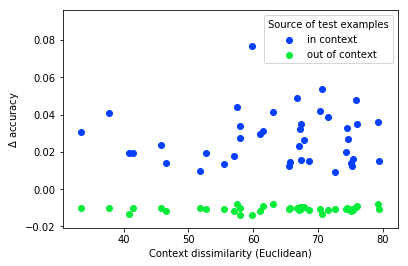

In [44]:
plt.scatter(context_distance('sim', 'euclidean'), df1['incontext_acc']-df0['incontext_base'], **scatter_styles['in'])
plt.scatter(context_distance('sim', 'euclidean'), df1['outofcontext_acc']-df0['outofcontext_base'], **scatter_styles['out'])
plt.legend(title='Source of test examples')
plt.xlabel('Context dissimilarity (Euclidean)')
plt.ylabel(r'$\Delta$ accuracy')
plt.show()

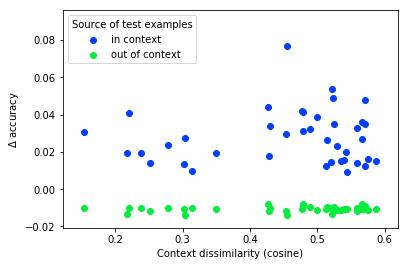

In [45]:
plt.scatter(context_distance('sim', 'cosine'), df1['incontext_acc']-df0['incontext_base'], **scatter_styles['in'])
plt.scatter(context_distance('sim', 'cosine'), df1['outofcontext_acc']-df0['outofcontext_base'], **scatter_styles['out'])
plt.legend(title='Source of test examples')
plt.xlabel('Context dissimilarity (cosine)')
plt.ylabel(r'$\Delta$ accuracy')
plt.show()